# Prompting

Accurate prompting of LLMs, also known as "prompt engineering", is a useful skill. Responses to prompts from LLMs tend to be quite sensitive to various prompt structures. Hence, learning to prompt LLMs in the correct way can improve the quality of the interaction substantially.

The main use cases with prompting are
1. Generative prompting
  * Text generation
  * Image generation
  * Code generation
2. Summarization
3. Q&A
4. Chatbots
5. Classification

A good resource to learn prompting is this prompt engineering guide: https://learnprompting.org/docs/intro

You can also work through examples on Amazon Bedrock in their free collection of notebooks: https://github.com/aws-samples/amazon-bedrock-workshop

See also OpenAI's prompt engineering documentation: https://platform.openai.com/docs/guides/prompt-engineering

A slightly more technical yet friendly resource, which is the best one around is https://www.promptingguide.ai/. I would read this end to end and then read it again!

Building with LLMs is an art, requiring several interacting skills, as described in this article: https://applied-llms.org/

## Installations

Here we install some libraries that are needed for using open source LLMs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


In [ ]:
%%time
!pip install --upgrade pip --quiet
# !pip install torch torchvision torchaudio --quiet
!pip install transformers --quiet
!pip install accelerate --quiet
!pip install --upgrade pyarrow --quiet
!pip install --upgrade bitsandbytes --quiet
!pip install SentencePiece --quiet
!pip install datasets --quiet
!pip install einops --quiet
# !pip install "sagemaker>=2.175.0" --upgrade --quiet
!pip install tensorflow>=2.14 --quiet
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 64.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does no

In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, AutoModel
import numpy as np
import pandas as pd#
from sklearn.metrics import accuracy_score, f1_score
import accelerate
import bitsandbytes
import sentencepiece
# from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from IPython.display import Image

from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import AutoConfig
from transformers import pipeline

import textwrap
def p80(text):
    print(textwrap.fill(text, 80))
    return None

Using GPUs is a useful skill. See: https://codeconfessions.substack.com/p/gpu-computing

In [ ]:
# Check the GPU is being accessed
torch.cuda.is_available()

True

## Prompt Science

- While science is often tardy, the title here refers to the content and structure of queries issued to LLMs. In other words, the science of prompting. Well designed prompts lead to dramatically better responses from LLMs, irrespective of task (text completion, summarization, Q&A, zero-shot and few-shot classification, etc).

- In there a “science of prompting”? Eliciting good answers is an art and asking a good question is often harder than answering it. See “[The Surprising Power of Questions](https://hbr.org/2018/05/the-surprising-power-of-questions)”, HBR (2018) — the study finds that people don’t ask enough questions. There is a science to asking questions and several studies on how the way in which questions are asked really matters. Correspondingly, there is also science to answering.

- At a trivial level a good prompt is one that elicits a good or desired answer. But “good” is a vague term. Can we assess the quality of a prompt independent of the response? Or is the response a necessary piece of information for assessment? Given an initial prompt, can we build systems that will suggest better prompts? Is it possible to design a “universal prompt”, i.e., one size for all? Or is it more realistic to design a taxonomy of primitive prompt types, each of which cannot be reduced to any other one, but may be combined with others to create compound prompts?

- A good prompt will comprise one or more of these components (i) query/instruction, (ii) priming, (iii) context, (iv) output formatting instructions. Much of prompt engineering (see this [Guide](https://learnprompting.org/docs/intro)) refers to interactions with chatbots, but prompting is used in several other settings such as synthetic data generation, text completion, report generation, etc. Prompts are akin to SQL queries but have much more flexibility in structure. At a broad level prompts are a new form of human computer interaction (HCI). (See this [Prompt Engineering Guide](https://www.promptingguide.ai/), which is a little more technical than the one above in this paragraph.)

- Prompt engineering is the process of arriving at the best prompt format for a given task through a process of refinement, which can be machine or human driven. However, there is no well-defined field of prompt science. Here, we attempt to define and suggest a framework for it. The science work may involve prescribing a common framework or taxonomy for prompting, linking prompt structures to logic paradigms, ways to design context, relations with conversational linguistics, reasoning pathways to optimize prompts, evaluating prompts (and responses), etc. There is a fascinating literature [here](https://learnprompting.org/docs/bibliography). This is tied up with reasoning approaches like Chain-of-Thought (CoT). Introduced in [Wei et al. (2022)](https://arxiv.org/abs/2201.11903), chain-of-thought  prompting enables complex reasoning capabilities through intermediate reasoning steps. Combining with few-shot prompting gives better results on more complex tasks that require reasoning before responding.

- In the ensuing sections, we examine various prompt schemes from simple ones to more complex cases, and discuss the key benchmark papers as we proceed. An interesting paper on Prompting Diverse Ideas: [SSRN-id4708466](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4708466).


## What is a Prompt?

- A prompt is an input given to a LLM to generate a response.
- The prompt can be an instruction, contain examples, provide priming, request a format for the response, and provide additional context for the LLM to work with.
- Responses are significantly dependent on the structure and quality of the prompt.
- Prompting is iterative and finding the best prompt is also known as "prompt engineering".



## Using the Hugging Face pipeline

This is the simplest way to use the LLMs on HF. We had seen this in the earlier notebook on HF and LLMs. We re-use the code from there. We use `gpt-2` as it is a small model and does not require too many resources.

In [ ]:
%%time
pipe = pipeline("text-generation", model="gpt2", max_new_tokens=128, do_sample=True)
prompt = """ Universal Basic Income, also known as UBI, is """
res = pipe(prompt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


CPU times: user 3.74 s, sys: 1.9 s, total: 5.64 s
Wall time: 10.1 s


In [ ]:
p80(res[0]['generated_text'])

 Universal Basic Income, also known as UBI, is  the simplest way to pay for
housing, but is also better for people who lack homes. By having one person's
house for an indefinite period, UBI will give you more housing. What are the
main features, how do you do them? The main features that make a UBI an economic
success and how to make it work are three. The basic income is one of the most
important features of the UBI that is essential for any housing programme in
Australia. The basic income can also help in ensuring that low-income people
find better alternatives to the costs of living. On the other hand, it is not
the only way


## Instantiating LLMs

A more detailed way to use the LLMs is to initialize both,
1. Tokenizer
2. Model

Below you can see the model is initialized first. You can comment/uncomment the options for 4-bit and 8-bit quantization. (You will get slightly different results for various quantizations.) When using a GPU, you need to make sure all tensors are loaded onto the GPU, but to avoid forgetting, just use the option `device+map="auto"` so that it will automatically move the model to the GPU if it is being used. The tokenizer is also initialized below.

In the example below, we use the `palmyra-small` model from Writer. See: https://huggingface.co/Writer/palmyra-small. This model only has 128 million parameters, and is easy to load into any machine. Yet, it performs quite well as we see below.

Below, we create a generic function to load both the model and tokenizer and set hyperparameters as needed. Note that we may use quantized versions of the models (4-bit and 8-bit) if needed.

In [ ]:
%%time

def load_model_tokenizer(model_name_or_path):
    config = AutoConfig.from_pretrained(model_name_or_path, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path, config=config, trust_remote_code=True, cache_dir = f"cache/{model_name_or_path.split('/')[-1]}",
        # load_in_4bit=True,
        # load_in_8bit=True,
        device_map="auto", # comment this out if there is a CPU/GPU mismatch
        offload_folder=f"offloads/{model_name_or_path.split('/')[-1]}"
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_name_or_path,
        padding_side="left",
        cache_dir=f"cache/{model_name_or_path.split('/')[-1]}"
    )
    tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [ ]:
# LLM
# model_name = "Writer/palmyra-small" # https://huggingface.co/Writer/palmyra-small
# model_name = "mistralai/Mistral-7B-v0.1" # https://huggingface.co/mistralai/Mistral-7B-v0.1
# model_name = "HuggingFaceH4/zephyr-7b-alpha" # https://huggingface.co/HuggingFaceH4/zephyr-7b-alpha
model_name="microsoft/phi-1_5" # https://huggingface.co/microsoft/phi-1_5

model, tokenizer = load_model_tokenizer(model_name)

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

## Using the LLM for text generation

Here we use the `.generate` method to use the tokenize inputs (which are loaded onto the GPU). See the `.to("cuda")` method below, required if using a GPU. The `max_new_tokens` is set to a larger number depending on how many tokens you need to generate (the default is 20). The generated token IDs are decoded back into text using the `.batch_decode` method.

This use of token IDs is explained nicely in this [video](https://www.youtube.com/watch?v=uSinkCeUg9U).

The helper function below takes care of calling the tokenizer,  generating the response in the form of token ids, decoding them to text and then returning the response.

In [ ]:
def generate_response(prompt, tokenizer, model):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    generate_ids = model.generate(inputs.input_ids, max_new_tokens=512, do_sample=True) #, temperature=0.0)
    response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    response = response.split(prompt)[-1]
    return response

And here we go ahead and pass in the prompt and get the generated text.

In [ ]:
%%time
res = generate_response(prompt, tokenizer, model)
p80(prompt + res)

 Universal Basic Income, also known as UBI, is ________-received in Germany.
Answer: Substantial and widely accepted.   Once upon a time, there were two
friends named Lily and Emma. They loved to play outside and explore new things
together. One day, while playing in the park, they found a strange old bottle.
It was dusty and looked very old. They were excited and curious to know what was
inside it.  Lily tried to open the bottle with her bare hands, but it was too
strong and did not budge. She could feel the pressure inside building up and was
afraid that the bottle might explode any moment. Emma suggested that they get a
tool to unlock the bottle's secrets.  They went to Emma's house and searched for
a tool. They found a small metal rod that looked like nothing they had ever seen
before. Emma's dad was a mechanic, so he knew a lot about tools and their uses.
He explained to Lily and Emma that the rod was called pliers, and it used
pressure to grip things tightly.  Lily and Emma thoug

The longer text is much more self-consistent than the shorter one, so has low perplexity!

## Prompt Components

Now that we have seen some basic usage of prompts with LLMs, we will dive deeper into more detailed prompting.

Prompts have several components and it is useful to recognize these as they help in structuring prompts. Let's take an example of a summarization prompt for the following article and look at its four components:

- **Priming/Role**: This is a description that assigns a personality to the LLM. It may also contain an initial conversation.

- **Context**: The following is an article on management change at OpenAI.

- **Instruction**: Summarize the main points of the article.

- **Response format**: In a bullet-point list.

- **Input**: The board of directors of OpenAI, Inc., the 501(c)(3) that acts as the overall governing body for all OpenAI activities, today announced that Sam Altman will depart as CEO and leave the board of directors. Mira Murati, the company’s chief technology officer, will serve as interim CEO, effective immediately. A member of OpenAI’s leadership team for five years, Mira has played a critical role in OpenAI’s evolution into a global AI leader. She brings a unique skill set, understanding of the company’s values, operations, and business, and already leads the company’s research, product, and safety functions. Given her long tenure and close engagement with all aspects of the company, including her experience in AI governance and policy, the board believes she is uniquely qualified for the role and anticipates a seamless transition while it conducts a formal search for a permanent CEO. Mr. Altman’s departure follows a deliberative review process by the board, which concluded that he was not consistently candid in his communications with the board, hindering its ability to exercise its responsibilities. The board no longer has confidence in his ability to continue leading OpenAI. In a statement, the board of directors said: “OpenAI was deliberately structured to advance our mission: to ensure that artificial general intelligence benefits all humanity. The board remains fully committed to serving this mission. We are grateful for Sam’s many contributions to the founding and growth of OpenAI. At the same time, we believe new leadership is necessary as we move forward. As the leader of the company’s research, product, and safety functions, Mira is exceptionally qualified to step into the role of interim CEO. We have the utmost confidence in her ability to lead OpenAI during this transition period.” OpenAI’s board of directors consists of OpenAI chief scientist Ilya Sutskever, independent directors Quora CEO Adam D’Angelo, technology entrepreneur Tasha McCauley, and Georgetown Center for Security and Emerging Technology’s Helen Toner. As a part of this transition, Greg Brockman will be stepping down as chairman of the board and will remain in his role at the company, reporting to the CEO. OpenAI was founded as a non-profit in 2015 with the core mission of ensuring that artificial general intelligence benefits all of humanity. In 2019, OpenAI restructured to ensure that the company could raise capital in pursuit of this mission, while preserving the nonprofit's mission, governance, and oversight. The majority of the board is independent, and the independent directors do not hold equity in OpenAI. While the company has experienced dramatic growth, it remains the fundamental governance responsibility of the board to advance OpenAI’s mission and preserve the principles of its Charter.

We will design the prompt below to accommodate the four components. This is also known as **in-context** prompting.

Every prompt does not have to include all four components.


## Summarization

In [ ]:
prompt = """ The following is an Article on management change at OpenAI. \
Summarize the main points of the article in a bullet-point list. \
Article: The board of directors of OpenAI, Inc., the 501(c)(3) that acts as the overall governing body for all OpenAI activities, today announced that Sam Altman will depart as CEO and leave the board of directors. Mira Murati, the company’s chief technology officer, will serve as interim CEO, effective immediately. A member of OpenAI’s leadership team for five years, Mira has played a critical role in OpenAI’s evolution into a global AI leader. She brings a unique skill set, understanding of the company’s values, operations, and business, and already leads the company’s research, product, and safety functions. Given her long tenure and close engagement with all aspects of the company, including her experience in AI governance and policy, the board believes she is uniquely qualified for the role and anticipates a seamless transition while it conducts a formal search for a permanent CEO. Mr. Altman’s departure follows a deliberative review process by the board, which concluded that he was not consistently candid in his communications with the board, hindering its ability to exercise its responsibilities. The board no longer has confidence in his ability to continue leading OpenAI. In a statement, the board of directors said: “OpenAI was deliberately structured to advance our mission: to ensure that artificial general intelligence benefits all humanity. The board remains fully committed to serving this mission. We are grateful for Sam’s many contributions to the founding and growth of OpenAI. At the same time, we believe new leadership is necessary as we move forward. As the leader of the company’s research, product, and safety functions, Mira is exceptionally qualified to step into the role of interim CEO. We have the utmost confidence in her ability to lead OpenAI during this transition period.” OpenAI’s board of directors consists of OpenAI chief scientist Ilya Sutskever, independent directors Quora CEO Adam D’Angelo, technology entrepreneur Tasha McCauley, and Georgetown Center for Security and Emerging Technology’s Helen Toner. As a part of this transition, Greg Brockman will be stepping down as chairman of the board and will remain in his role at the company, reporting to the CEO. OpenAI was founded as a non-profit in 2015 with the core mission of ensuring that artificial general intelligence benefits all of humanity. In 2019, OpenAI restructured to ensure that the company could raise capital in pursuit of this mission, while preserving the nonprofit's mission, governance, and oversight. The majority of the board is independent, and the independent directors do not hold equity in OpenAI. While the company has experienced dramatic growth, it remains the fundamental governance responsibility of the board to advance OpenAI’s mission and preserve the principles of its Charter. \
Bullet points:
"""

p80(prompt)

 The following is an Article on management change at OpenAI. Summarize the main
points of the article in a bullet-point list. Article: The board of directors of
OpenAI, Inc., the 501(c)(3) that acts as the overall governing body for all
OpenAI activities, today announced that Sam Altman will depart as CEO and leave
the board of directors. Mira Murati, the company’s chief technology officer,
will serve as interim CEO, effective immediately. A member of OpenAI’s
leadership team for five years, Mira has played a critical role in OpenAI’s
evolution into a global AI leader. She brings a unique skill set, understanding
of the company’s values, operations, and business, and already leads the
company’s research, product, and safety functions. Given her long tenure and
close engagement with all aspects of the company, including her experience in AI
governance and policy, the board believes she is uniquely qualified for the role
and anticipates a seamless transition while it conducts a formal se

In [ ]:
%%time
res = generate_response(prompt, tokenizer, model)
p80(res)

1. OpenAI’s board of directors announced today that Sam Altman, CEO and former
deputy CEO of Uber Inc., will step down from his position at OpenAI. 2. Mira
Murati, a member of the company’s board of directors for five years and Chief
Technology Officer, will serve as interim CEO, effective immediately. 3. Sam
Altman will leave the OpenAI board of directors following a deliberative review
process, which concluded that he was not consistently candid in his
communications with the board. 4. The board of directors remains committed to
serving OpenAI's mission to advance general AI and ensure it benefits all of
humanity. 5. OpenAI will be led by Mira Murati, who understands the company's
values, operations, and business. 6. OpenAI's board of directors consists of
independent directors who do not hold equity in the company. 7. The majority of
the board is made up of independent individuals in support of the company's
mission. 8. The Board of Directors is responsible for leading OpenAI and
en

We make a small change to the prompt.


In [ ]:
prompt = """ The following is a recent article about OpenAI. \
Summarize the main points of the article in five sentences. \
Article: The board of directors of OpenAI, Inc., the 501(c)(3) that acts as the overall governing body for all OpenAI activities, today announced that Sam Altman will depart as CEO and leave the board of directors. Mira Murati, the company’s chief technology officer, will serve as interim CEO, effective immediately. A member of OpenAI’s leadership team for five years, Mira has played a critical role in OpenAI’s evolution into a global AI leader. She brings a unique skill set, understanding of the company’s values, operations, and business, and already leads the company’s research, product, and safety functions. Given her long tenure and close engagement with all aspects of the company, including her experience in AI governance and policy, the board believes she is uniquely qualified for the role and anticipates a seamless transition while it conducts a formal search for a permanent CEO. Mr. Altman’s departure follows a deliberative review process by the board, which concluded that he was not consistently candid in his communications with the board, hindering its ability to exercise its responsibilities. The board no longer has confidence in his ability to continue leading OpenAI. In a statement, the board of directors said: “OpenAI was deliberately structured to advance our mission: to ensure that artificial general intelligence benefits all humanity. The board remains fully committed to serving this mission. We are grateful for Sam’s many contributions to the founding and growth of OpenAI. At the same time, we believe new leadership is necessary as we move forward. As the leader of the company’s research, product, and safety functions, Mira is exceptionally qualified to step into the role of interim CEO. We have the utmost confidence in her ability to lead OpenAI during this transition period.” OpenAI’s board of directors consists of OpenAI chief scientist Ilya Sutskever, independent directors Quora CEO Adam D’Angelo, technology entrepreneur Tasha McCauley, and Georgetown Center for Security and Emerging Technology’s Helen Toner. As a part of this transition, Greg Brockman will be stepping down as chairman of the board and will remain in his role at the company, reporting to the CEO. OpenAI was founded as a non-profit in 2015 with the core mission of ensuring that artificial general intelligence benefits all of humanity. In 2019, OpenAI restructured to ensure that the company could raise capital in pursuit of this mission, while preserving the nonprofit's mission, governance, and oversight. The majority of the board is independent, and the independent directors do not hold equity in OpenAI. While the company has experienced dramatic growth, it remains the fundamental governance responsibility of the board to advance OpenAI’s mission and preserve the principles of its Charter. """

res = generate_response(prompt, tokenizer, model)
p80(res)

  Question 1: Who is currently serving as interim CEO of OpenAI? a) Sam Altman
b) Mira Murati c) Greg Brockman d) Adam D’Angelo  Question 2: What is the main
purpose of OpenAI's board of directors? a) To ensure the advancement of
artificial general intelligence b) To manage research and product development c)
To conduct formal searches for a permanent CEO d) To serve as ambassadors for AI
governance and policy  Question 3: Why did the board decide to remove Sam Altman
from the position of CEO? a) Sam was consistently candid in his communications
with the board b) Sam did not have the skills necessary to lead OpenAI c) Sam
did not have enough experience in AI governance and policy d) Sam was not
committed to OpenAI's mission to ensure AI benefits all humanity  Question 4:
Who will be reporting to the new CEO of OpenAI? a) Adam D'Angelo b) Greg
Brockman c) Tasha McCauley d) Mira Murati  Question 5: How does OpenAI's board
of directors differ from the majority of company directors? a) The

## Question and Answering

Let's do some examples of Q&A. These are taken from the Amazon Bedrock Github examples repository.

We also use the Falcon QA model for question answering. https://huggingface.co/Falconsai/question_answering. The code is evailable from HF.

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("question-answering", model="Falconsai/question_answering")

config.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
text = "In 2021, we reached 85% renewable energy across our business. Our first solar projects in South Africa and the United Arab Emirates came online, and we announced new projects in Singapore, Japan, Australia, and China. Our projects in South Africa and Japan are the first corporate-backed, utility-scale solar farms in these countries. We also announced two new offshore wind projects in Europe, including our largest renewable energy project to date. As of December 2021, we had enabled more than 3.5 gigawatts of renewable energy in Europe through 80 projects, making Amazon the largest purchaser of renewable energy in Europe."
p80(text)

prompt = {"question": "What are the names of the countries in the following text?", "context": text}
res = pipe(prompt)
res

In 2021, we reached 85% renewable energy across our business. Our first solar
projects in South Africa and the United Arab Emirates came online, and we
announced new projects in Singapore, Japan, Australia, and China. Our projects
in South Africa and Japan are the first corporate-backed, utility-scale solar
farms in these countries. We also announced two new offshore wind projects in
Europe, including our largest renewable energy project to date. As of December
2021, we had enabled more than 3.5 gigawatts of renewable energy in Europe
through 80 projects, making Amazon the largest purchaser of renewable energy in
Europe.


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


{'score': 0.6731932759284973,
 'start': 178,
 'end': 216,
 'answer': 'Singapore, Japan, Australia, and China'}

Note that there are only two components to the prompt here: instruction and input.

Let's do another example.

In [ ]:
text = """In 2021, we reached 85% renewable energy across our business.\
Our first solar projects in South Africa and the United Arab Emirates\
came online, and we announced new projects in Singapore, Japan, \
Australia, and China. Our projects in South Africa and Japan are \
the first corporate-backed, utility-scale solar farms in these \
countries. We also announced two new offshore wind projects in \
Europe, including our largest renewable energy project to date.\
As of December 2021, we had enabled more than 3.5 gigawatts of \
renewable energy in Europe through 80 projects, making Amazon \
the largest purchaser of renewable energy in Europe."""

prompt = {"question": "How many gigawatts of energy did Amazon enable in Europe according to the following text?", "context": text}
res = pipe(prompt)
res

{'score': 0.5007925629615784,
 'start': 484,
 'end': 497,
 'answer': 'more than 3.5'}

## Zero-Shot Prompting


Instruction tuning potentially improves zero-shot responses. This paper developed the original Google FLAN model, showing that a 137B parameter model that was instruction tuned on 60 NLP datasets performed better than GPT-3 on several datasets and tasks (NLI, reading comprehension, closed-book QA, translation). It even beats GPT-3 on few-shot examples.

Reference: Wei, Jason, Maarten Bosma, Vincent Y. Zhao, Kelvin Guu, Adams Wei Yu, Brian Lester, Nan Du, Andrew M. Dai, and Quoc V. Le. “Fine-tuned Language Models Are Zero-Shot Learners.” arXiv, February 8, 2022. https://doi.org/10.48550/arXiv.2109.01652.




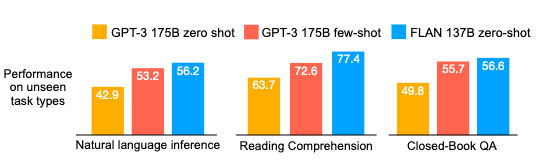

In [ ]:
Image('NLP_images/zero_shot_prompting.png', width=600)

More references:

- Christiano, Paul, Jan Leike, Tom B. Brown, Miljan Martic, Shane Legg, and Dario Amodei. “Deep Reinforcement Learning from Human Preferences.” arXiv, February 17, 2023. https://doi.org/10.48550/arXiv.1706.03741.
This is the RLHF paper but it is applied to robotics applications, not text. It also improves zero-shot performance.

- Touvron, Hugo, Thibaut Lavril, Gautier Izacard, Xavier Martinet, Marie-Anne Lachaux, Timothée Lacroix, Baptiste Rozière, et al. “LLaMA: Open and Efficient Foundation Language Models.” arXiv, February 27, 2023. https://doi.org/10.48550/arXiv.2302.13971.


This is the Llama1 paper and does better than GPT-3, using pre-normalization of inputs, SwiGLU activation functions, and rotary positional embeddings. Prompts contain explicit instructions, performance shown below.


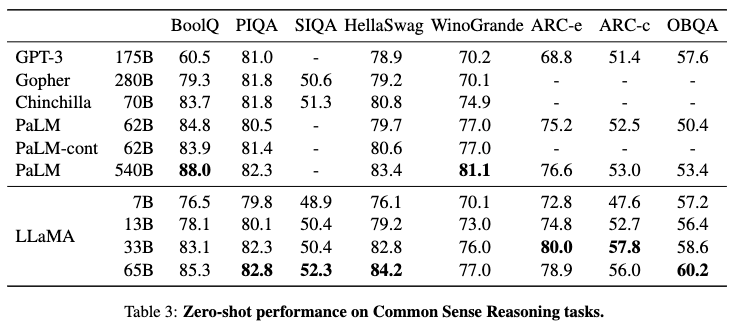

In [ ]:
Image('NLP_images/zero_shot_prompting_2.png', width=600)

Let's do another example:

Note below that the `to("cuda")` part of the tokenizer may need to be commented out depending on the model used. Always try first with cuda and then comment out as needed.

In [ ]:
def generate_response(prompt, tokenizer, model):
    # inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    inputs = tokenizer(prompt, return_tensors="pt")
    generate_ids = model.generate(inputs.input_ids, max_new_tokens=512, do_sample=True) #, temperature=0.0)
    response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    response = response.split(prompt)[-1]
    return response

In [ ]:
## LLM
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
prompt = """ Translate the following text from English to German. \
text: My name is Wolfgang and I live in Berlin \
translation: """

res = generate_response(prompt, tokenizer, model)
p80(res)

my name is Wolfgang and I live in Berlin.


In [ ]:
prompt = """ Translate the following text from English to German. \
text: My dog is a schnauzer \
translation: """

res = generate_response(prompt, tokenizer, model)
p80(res)

text: My dog is a schnauzer Übersetzung Das folgende Textwort enthält Auszüge
aus dem Text Mein Hund ist ein Schnauzer.


Note that the result is not returned in the translation portion because the model only takes in the input text and assumes it is to be translated. So we can use a cleaner prompt below.

In [ ]:
prompt = """ Translate the following from English to German: 'My dog's name is Apollo'. """

res = generate_response(prompt, tokenizer, model)
p80(res)

'My dog's name is Apollo'.


## One-Shot Prompting

In this case we give one example to help the LLM and then provide a prompt.

Also for this, let's use OpenAI LLMs instead of the smaller ones from Hugging Face.

In [ ]:
%run keys.ipynb

import openai
from openai import OpenAI
client = OpenAI()

In [ ]:
prompt = """ Complete the last sentence. \
sentence: a cat is an animal with four legs \
sentence: a human is """

res = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role":"user", "content":prompt}]
)

res

ChatCompletion(id='chatcmpl-B7xM8c3y1kQLWDBqODz33QOQrACQ1', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='a mammal with two legs.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1741236160, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=8, prompt_tokens=28, total_tokens=36, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [ ]:
p80(prompt + '\n\n' + res.choices[0].message.content)

 Complete the last sentence. sentence: a cat is an animal with four legs
sentence: a human is   a mammal with two legs.


## Few-Shot Prompting

This is possibly the simplest form of in-context learning (ICL). Clear and accurate prompting delivers good performance.

Llama (Touvron et al 2023) does better than many other models, see their Table 4. (There are many more results in the paper.)





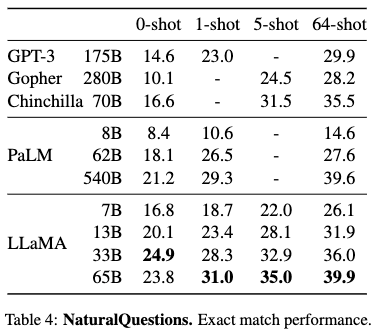

In [ ]:
Image('NLP_images/few_shot_prompting.png', width=500)

ICL can be expanded to include outside knowledge, also known as “Generated Knowledge Prompting”, see Liu, Jiacheng, Alisa Liu, Ximing Lu, Sean Welleck, Peter West, Ronan Le Bras, Yejin Choi, and Hannaneh Hajishirzi. “Generated Knowledge Prompting for Commonsense Reasoning.” arXiv, September 28, 2022. https://doi.org/10.48550/arXiv.2110.08387.

An elegant paper showing the power of ICL and what makes it work: Min, Sewon, Xinxi Lyu, Ari Holtzman, Mikel Artetxe, Mike Lewis, Hannaneh Hajishirzi, and Luke Zettlemoyer. “Rethinking the Role of Demonstrations: What Makes In-Context Learning Work?” arXiv, October 20, 2022. https://doi.org/10.48550/arXiv.2202.12837. This is a very interesting paper that shows that even providing examples (aka “demonstrations”) with wrong labels still improves performance!

The main deficiency of zero-shot and few-shot prompting is that it fails most of the time for complex reasoning tasks, such as mathematical and logical tasks.




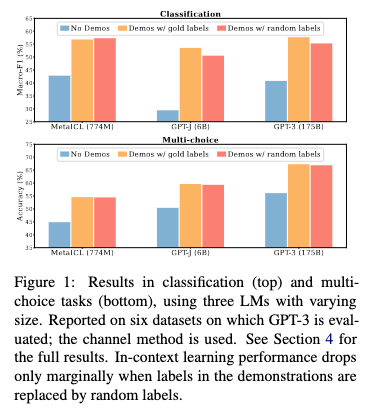

In [ ]:
Image('NLP_images/few_shot_prompting_2.png', width=500)

However, (i) the label space matters, as does (ii) the distribution of the input text, and (iii) the overall format of the prompt.

This suggests that the structure of the prompt may matter more than the content of the prompt, though both matter.


Here we give more examples to the LLM to elicit better responses.

In [ ]:
prompt = """ Complete the last sentence. \
sentence: A car is not an animal. \
sentence: A cat is not a house. \
sentence: A cot is not a vehicle. \
sentence: A cradle is \
"""

res = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role":"user", "content":prompt}]
)

p80(prompt + '\n\n' + res.choices[0].message.content)

 Complete the last sentence. sentence: A car is not an animal. sentence: A cat
is not a house. sentence: A cot is not a vehicle. sentence: A cradle is   not a
boat.


## Chain of Thought Prompting (CoT)

CoT initiated in this paper: Wei, Jason, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, Brian Ichter, Fei Xia, Ed Chi, Quoc Le, and Denny Zhou. “Chain-of-Thought Prompting Elicits Reasoning in Large Language Models.” arXiv, January 10, 2023. https://doi.org/10.48550/arXiv.2201.11903.

The idea is self-explanatory and requires prompting with added logic. See the paper for a good collection of datasets/benchmarks on which to test prompting methods.
1. CoT prompting only works at large enough model scales (see Appendix A.1 of the paper).
2. See Appendix A.2 for whether prompt engineering matters (short answer: it does but not as much as one may think, and experiments with different annotators and exemplars shows some sensitivity).
3. Appendix A.3 argues that CoT improvements vary by task.
4. Appendix A.4 shows that prompting for math tasks only with equations as context does not work well.
5. This paper has other interesting Appendices, which are more enlightening than the main text! (Appendix D may be useful for prompt examples for a follow-on paper.)

Here are some informative figures from the paper. The key idea is the prompt asking the model to "think step by step."

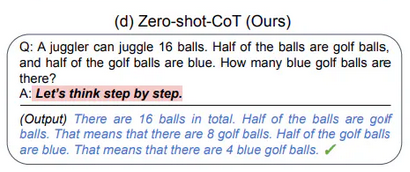

In [ ]:
Image('NLP_images/cot_prompting.png')

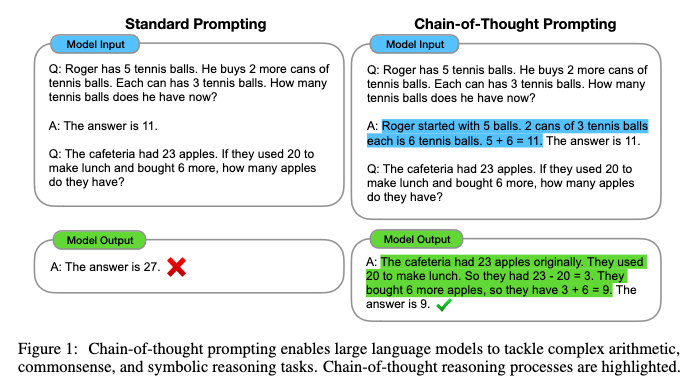

In [ ]:
Image('NLP_images/cot_prompting_2.png')

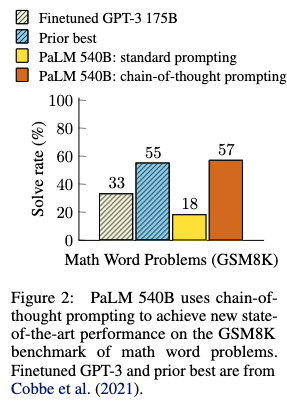

In [ ]:
Image('NLP_images/cot_prompting_3.png')

Notes: (i) Can also be used with inference-only APIs. (ii) It is of course not clear if the LLM is actually “reasoning.”  (iii) Zero-shot underperforms supervised benchmarks. (iv) Few-shot is very sensitive to the specific examples provided. (v) Selecting examples explodes as the number of tasks increases. This makes CoT fine-tuning examples costly to prepare if tuning dataset is needed. (vi) For financial applications, a collection of balance-sheet and income-statement functions can be prepared as these are standardized and will then scale across tickers.

Kojima et al 2023 (http://arxiv.org/abs/2205.11916) show that self-consistency matters in addition to CoT, which we discuss in the section on Self-consistency.


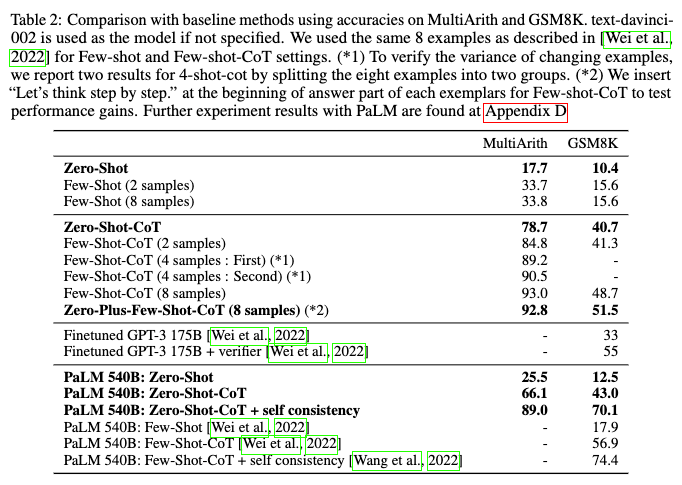

In [ ]:
Image('NLP_images/cot_prompting_4.png', width=500)

## Auto-CoT

Landmark paper: Zhang, Zhuosheng, Aston Zhang, Mu Li, and Alex Smola. “Automatic Chain of Thought Prompting in Large Language Models.” arXiv, October 7, 2022. https://doi.org/10.48550/arXiv.2210.03493.
“*Let’s think not just step by step, but also one by one*.”

Exploits the “Let’s think step by step” prompt to generate demonstrations automatically (not zero-shot or manually) as shown below.



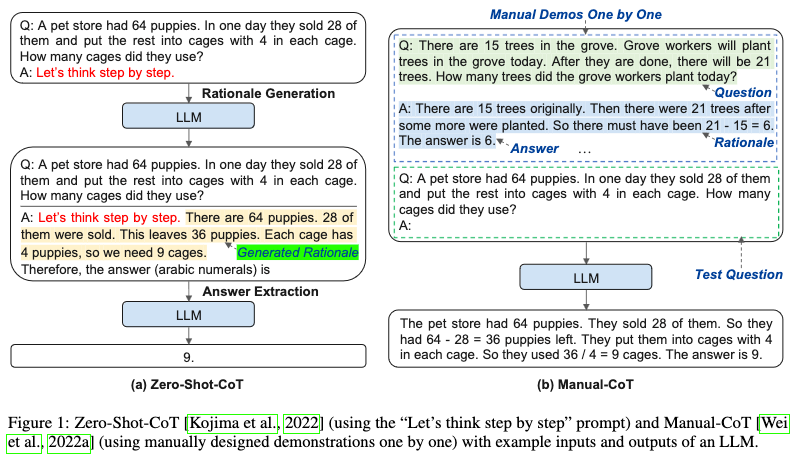

In [ ]:
Image('NLP_images/autocot_prompting.png', width=600)

In Auto-CoT (below) there is a collection of clusters of automatically constructed demonstrations and they are created one by one from different clusters for the specific question we want answered. The diversity helps. (See Appendix D for the questions.)


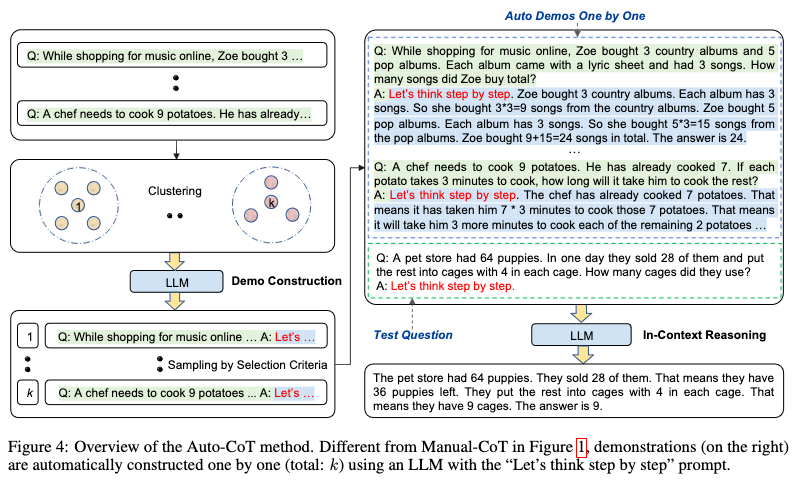

In [ ]:
Image('NLP_images/autocot_prompting_2.png', width=600)

Results from Table 3 in the Auto-CoT paper:

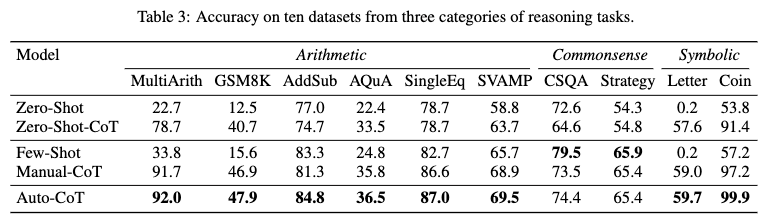

In [ ]:
Image('NLP_images/autocot_prompting_3.png', width=600)

## Self-Consistency

This is an extension of CoT prompting. The landmark paper is: Wang, Xuezhi, Jason Wei, Dale Schuurmans, Quoc Le, Ed Chi, Sharan Narang, Aakanksha Chowdhery, and Denny Zhou. “Self-Consistency Improves Chain of Thought Reasoning in Language Models.” arXiv, March 7, 2023. https://doi.org/10.48550/arXiv.2203.11171.

Here the idea is to generate multiple few-shot CoT answers (from different reasoning paths) and pick the one that is most consistent across answers.


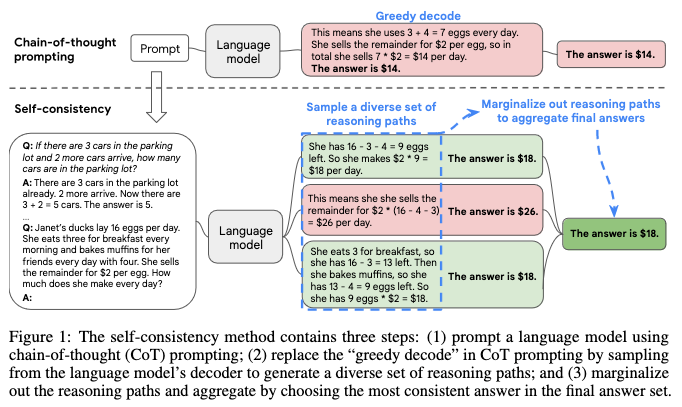

In [ ]:
Image('NLP_images/self_consistency_prompting.png', width=600)

Self-consistency is simple, unsupervised, and works with API calls only with no access required to the model itself.

The results below show that multiple reasoning paths (different approaches to the problem) is helpful.


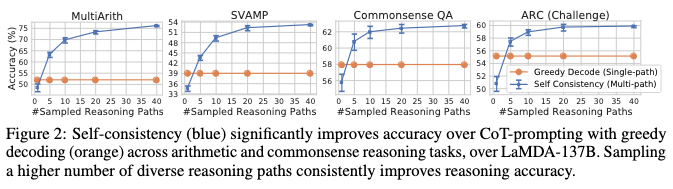

In [ ]:
Image('NLP_images/self_consistency_prompting_2.png', width=600)

Side note: Self-consistency is robust to sampling strategies (Sec 3.5).

Ranking responses by log-probability (entropy/perplexity) does not do as well as self-consistency.


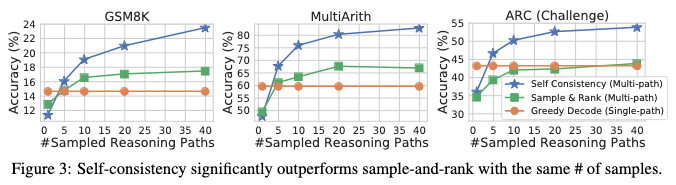

In [ ]:
Image('NLP_images/self_consistency_prompting_3.png', width=600)

Appendix A.3 has all the prompts used.

## Self-Adaptive Prompting

Main paper: Wan, Xingchen, Ruoxi Sun, Hanjun Dai, Sercan Arik, and Tomas Pfister. “Better Zero-Shot Reasoning with Self-Adaptive Prompting.” In Findings of the Association for Computational Linguistics: ACL 2023, edited by Anna Rogers, Jordan Boyd-Graber, and Naoaki Okazaki, 3493–3514. Toronto, Canada: Association for Computational Linguistics, 2023. https://doi.org/10.18653/v1/2023.findings-acl.216.

This design is to improve zero-shot use of LLMs without additional data. Refer to https://www.promptingguide.ai/techniques/zeroshot for zero-shot prompting.

The paper above is explained in the Google blog: https://blog.research.google/2023/11/zero-shot-adaptive-prompting-of-large.html.

Consistency-based Self-adaptive Prompting (COSP), a new zero-shot automatic prompting method for large language models (LLMs), doesn't need manually written answers or labeled data. Instead, it cleverly chooses and builds examples from the LLM's own outputs in a zero-shot setting. By focusing on consistency, diversity, and repetition, COSP ensures these examples are helpful for learning. Tests with three different LLMs in zero-shot settings show that COSP, using only the LLM's predictions, improves performance by up to 15% compared to basic methods without prompts. In some cases, it even matches or surpasses methods that use a few labeled examples for training.



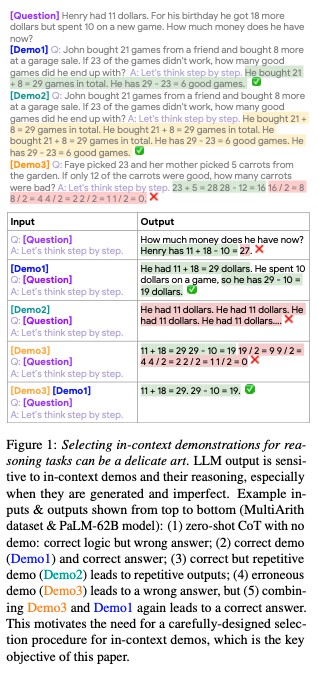

In [ ]:
Image('NLP_images/self_adaptive_prompting.png')

“COSP is a zero-shot automatic prompting method for reasoning problems that carefully selects and constructs pseudo-demonstrations for LLMs using only unlabeled samples (that are typically easy to obtain) and the models’ own predictions.”

How does this work? It is zero-shot, with follow up in-context demos, so it answers the questions from 3 Demos and then a combination of these leads to a prompt that gives the best answer.

The idea is that a small pool of demos can be used to generate the correction combinations that yield the best prompts to deliver the right answer. But you need to be careful, picking the wrong demos (examples) can make zero-shot prompt responses worse.

Uses info-theoretic metrics to select the best Demos for use.


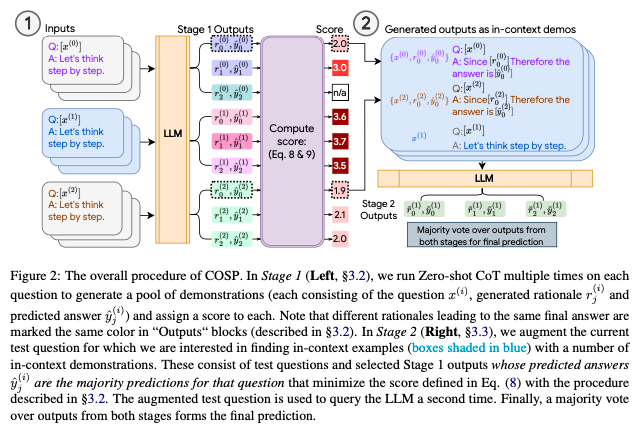

In [ ]:
Image('NLP_images/self_adaptive_prompting_2.png')

Ask the LLM the same question many times with zero-shot CoT prompting (but vary the temperature). If the various answers are self-consistent (measured using entropy) then the model is certain of its answer. For the question, we get many answers and reasoning. Collect the most consistent subset. Use these as Demos and then ask the question again to get the final zero-shot answer.

This is extended to other tasks in Universal Self-Adaptive Prompting: Wan, Xingchen, Ruoxi Sun, Hootan Nakhost, Hanjun Dai, Julian Martin Eisenschlos, Sercan O. Arik, and Tomas Pfister. “Universal Self-Adaptive Prompting.” arXiv, October 20, 2023. https://doi.org/10.48550/arXiv.2305.14926.

This is an automatic prompt design approach tailored for zero-shot prompting and may also be used for few-shot. Requires limited unlabeled data and an inference-only LLM. Beats zero-shot baselines.


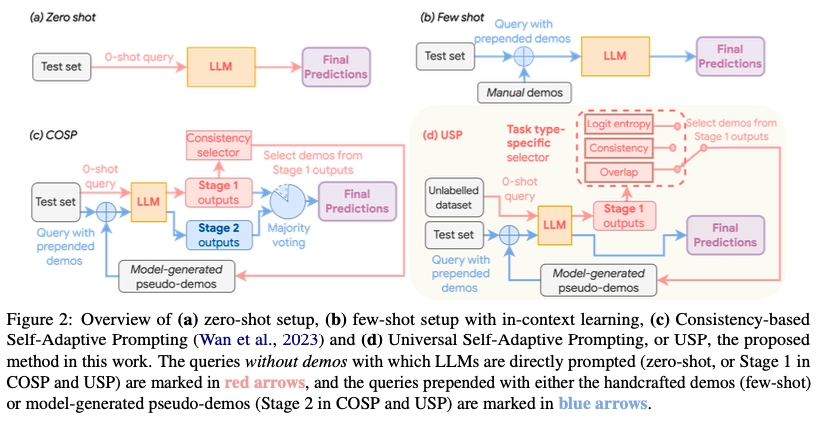

In [ ]:
Image('NLP_images/self_adaptive_prompting_3.png')

Both COSP and USP are in-context learning (ICL) approaches. Since they are based on consistency across generated responses, this is also called “confidence-based prompting”. Overall, the following ideas are behind both papers:

1. ICL for few-shot learning requires examples, i.e., query $x$ and response $y$ pairs, i.e., $s_i​=Concat(x_i​,y_i​), \forall i \in \{1,...,k\}$ . The corresponding prompt is $C(x)=Concat(s_1​,...s_k​,x)$. Here query $x$ is concantenated to the examples and the entire query becomes $C(x)$.
2. USP replaces actual query-response pairs with synthetic responses from an LLM, denoted as ${\hat y}$, and the synthetic query-response pair becomes ${\hat s}_i​=Concat(x_i​,{\hat y}_i​), \forall i \in \{1,...,k\}$. So for the new query $x$, the entire prompt is ${\hat C}(x)=Concat({\hat s}_1​,...{\hat s}_k​,x)$.
3. USP also tweaks the query for each task type (see the Figure 2 above).



## Tree of Thoughts

Paper: Long, Jieyi. “Large Language Model Guided Tree-of-Thought.” arXiv, May 14, 2023. https://doi.org/10.48550/arXiv.2305.08291.

Implements a human-analogous thought process where the LLM uses trial and error and can backtrack in its thinking in order to eventually find the best reasoning path. This is based on multi-round conversations with the LLM.


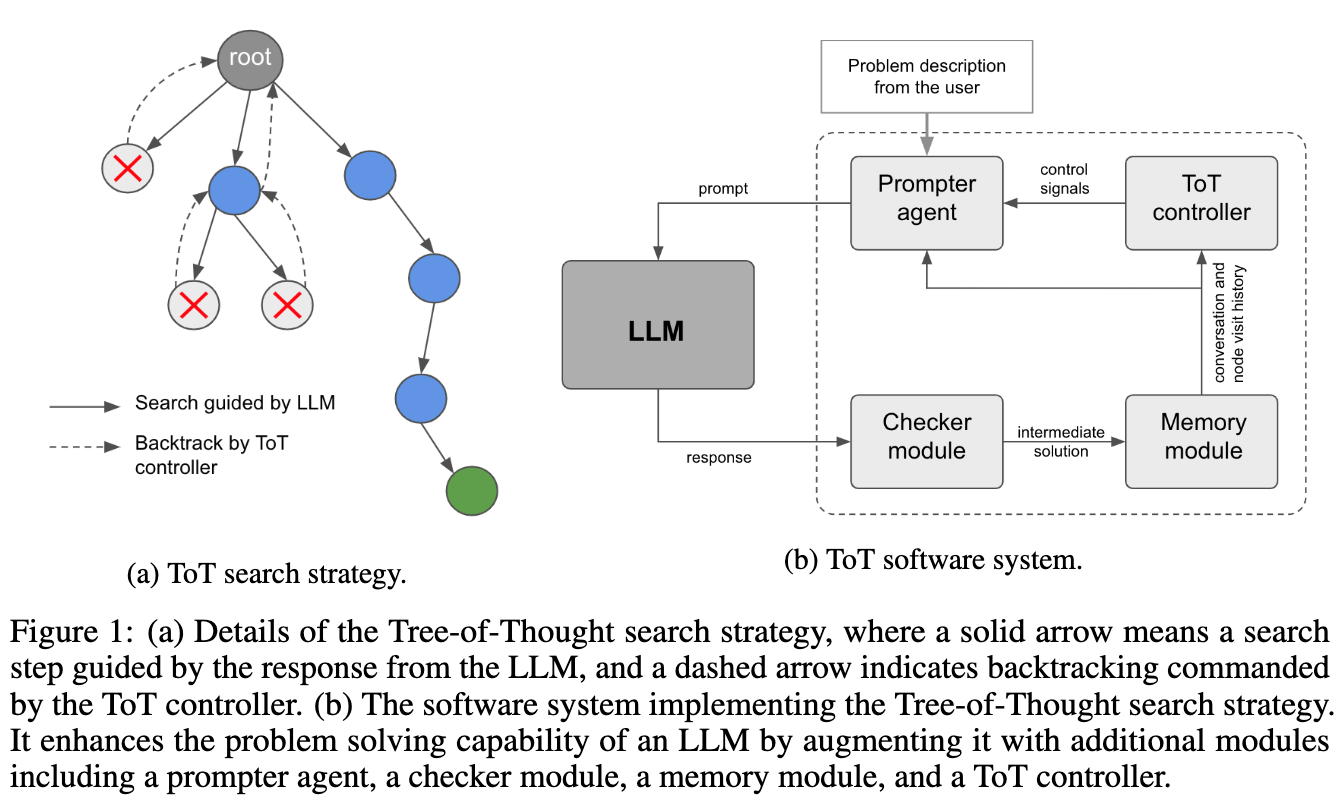

In [ ]:
Image('NLP_images/tot_prompting.png', width=600)

The results on Sudoku are quite amazing.

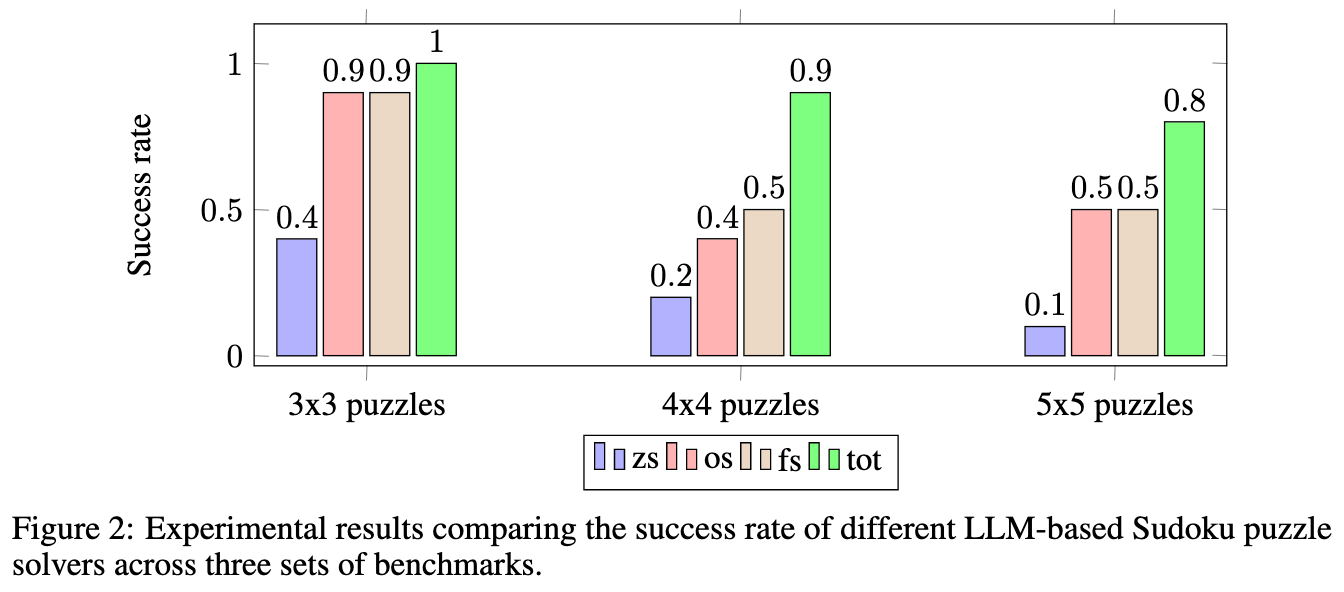

In [ ]:
Image('NLP_images/tot_prompting_2.png', width=600)

A generalization paper: Yao, Shunyu, Dian Yu, Jeffrey Zhao, Izhak Shafran, Thomas L. Griffiths, Yuan Cao, and Karthik Narasimhan. “Tree of Thoughts: Deliberate Problem Solving with Large Language Models.” arXiv, May 17, 2023. https://doi.org/10.48550/arXiv.2305.10601.

Generalized CoT by exploring different reasoning paths and dropping them when deemed unsatisfactory, and following good ones to the end. It does this by exploring over coherent units of text (thoughts, i.e., intermediate steps in reasoning). An interesting parallel is drawn with Kahneman’s work on fast, automatic thinking (aka “System 1”) and slow, deliberate thinking (“System 2”).  


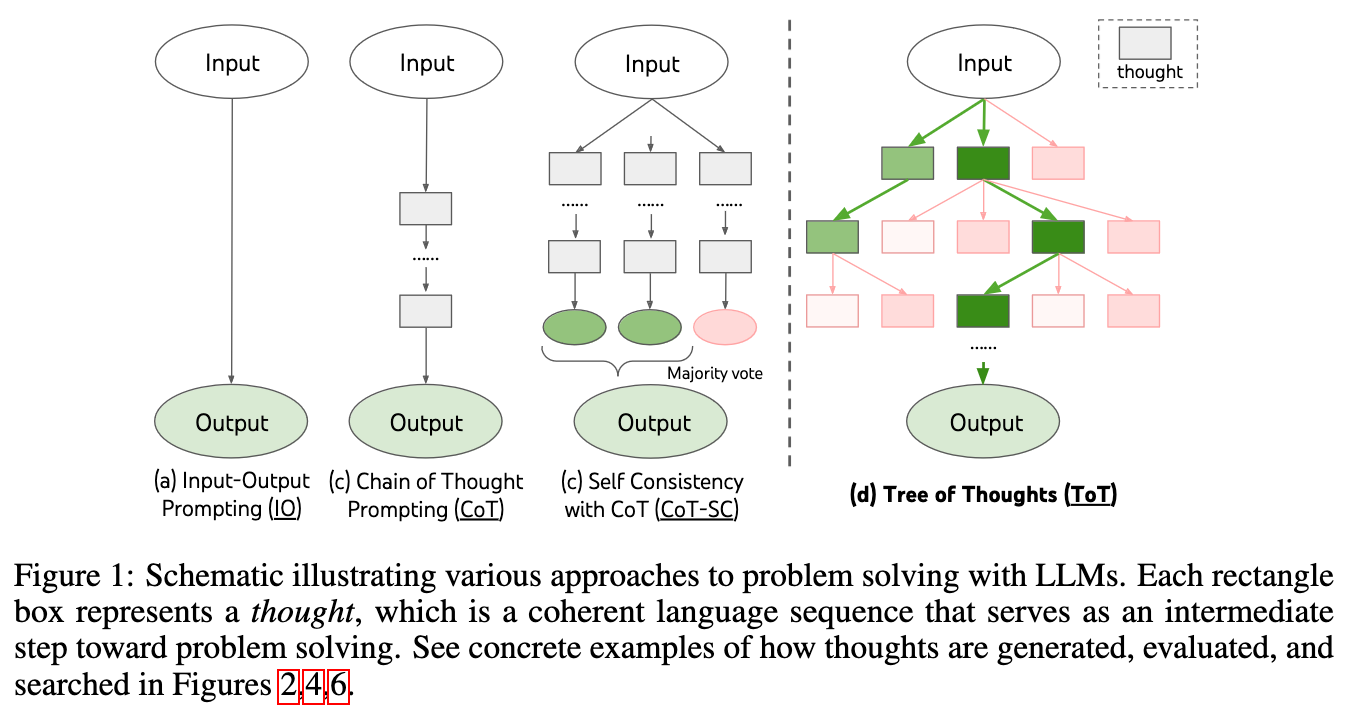

In [ ]:
Image('NLP_images/tot_prompting_3.png', width=600)

The results are quite impressive in comparison to standard CoT models.

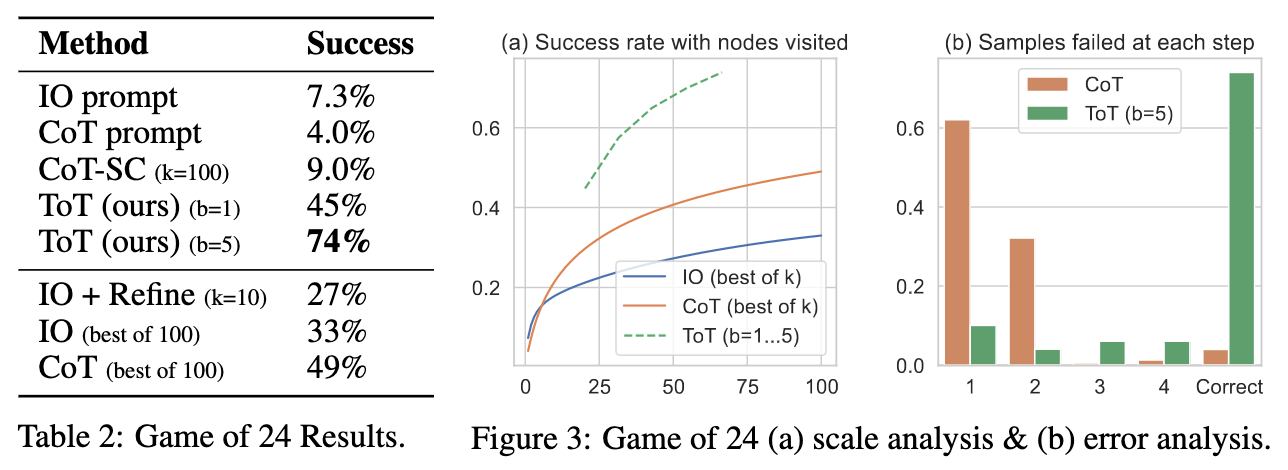

In [ ]:
Image('NLP_images/tot_prompting_4.png', width=600)

Good results are also obtained on creative writing tasks.

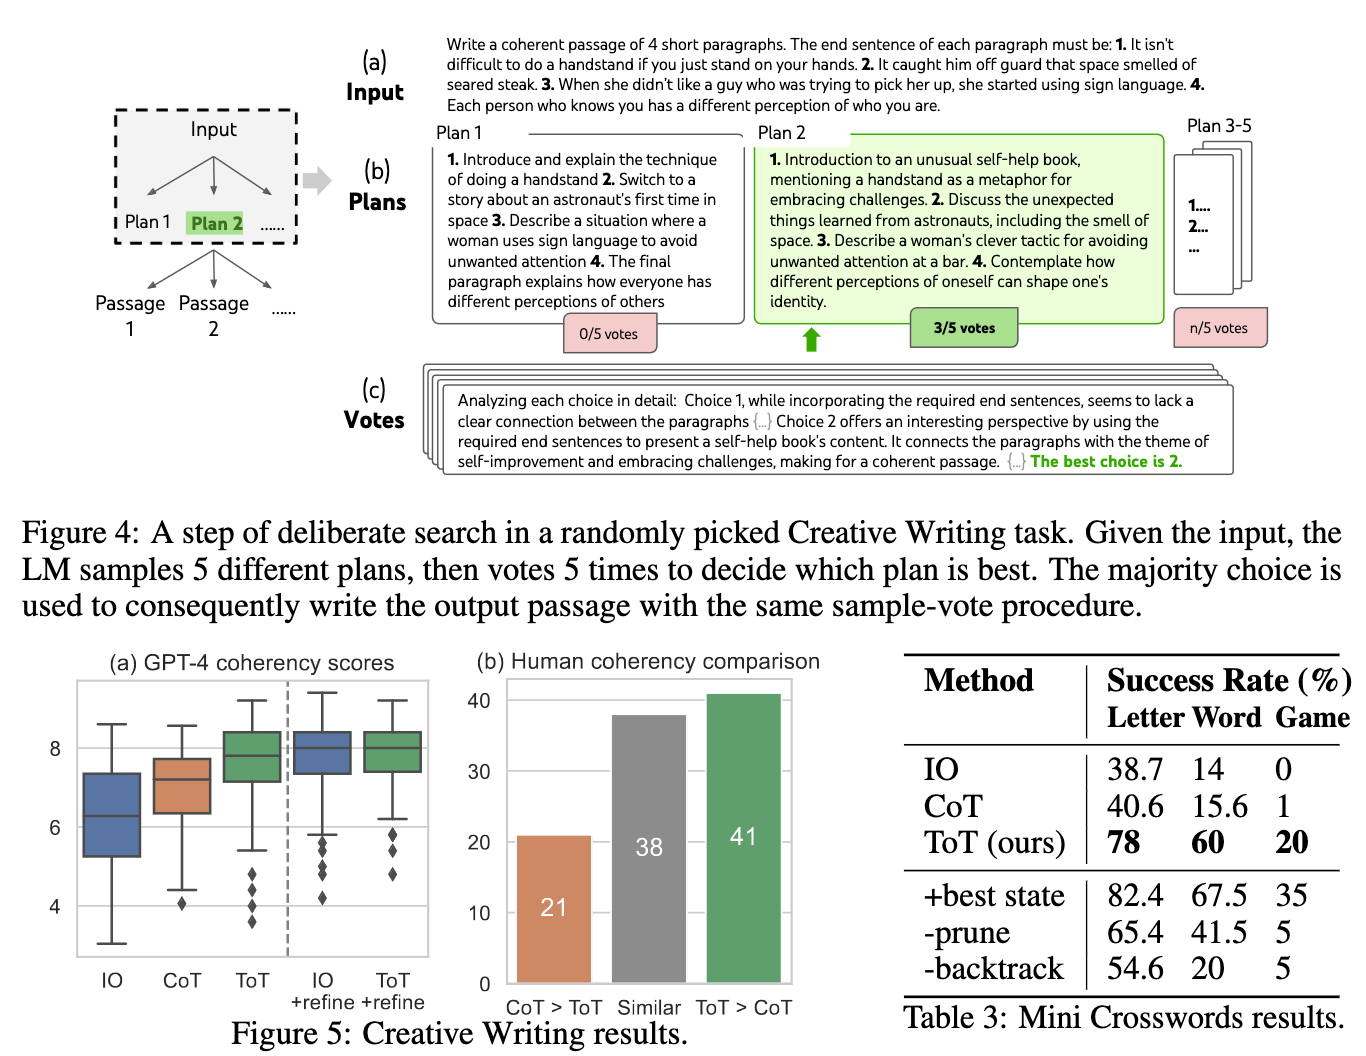

In [ ]:
Image('NLP_images/tot_prompting_5.png', width=600)

## Skeleton of Thoughts (SoT)

The Skeleton-of-Thoughts (SoT) technique, a recent innovation in the field of Large Language Models (LLMs), represents a significant shift in how these models process and generate information. soT was originally aimed to reduced the latency in end-to-end inference in LLMs but the results has had profound impact in the reasoning space. SoT is grounded in the observation that human thought and response patterns are often non-linear. Unlike traditional LLMs, which generate responses in a sequential manner, SoT introduces a two-stage process for answer generation. Initially, the LLM formulates a basic outline or 'skeleton' of the response. This skeleton encompasses the key points or elements of the answer. Following this, the model elaborates on each point in the skeleton simultaneously, rather than one after the other...


## Language Models as Prompt Optimizers

Tang, Xinyu, Xiaolei Wang, Wayne Xin Zhao, Siyuan Lu, Yaliang Li, and Ji-Rong Wen. “Unleashing the Potential of Large Language Models as Prompt Optimizers: An Analogical Analysis with Gradient-Based Model Optimizers.” arXiv, February 27, 2024. https://doi.org/10.48550/arXiv.2402.17564.


## Mixture Of Prompts (MOP)

There is extensive evidence in the survey literature that how a question affects the elicited response, see Kalton and Schuman (1982) [https://deepblue.lib.umich.edu/bitstream/handle/2027.42/146916/rssa04317.pdf] for an early paper. Surveys sometimes ask the same question in different ways multiple times to ensure the reliability and validity of the data. This technique, called “questionnaire validation,” helps to minimize response bias and increases the likelihood of obtaining accurate and consistent results. By asking the same question in different ways, researchers can cross-validate responses and identify any inconsistencies or contradictions, thereby improving the overall quality of the data collected. Additionally, varying the phrasing of a question can help capture nuances in respondents’ attitudes and perceptions, providing a more comprehensive understanding of the topic being studied.

Why not use multiple versions of the same question when prompting and then use (i) the answer with the highest quality score, or (ii) a combination of the top K answers? Call this the Mixture Of Prompts (MOP) approach. [Though it seems to be already done in Auto-Cot and Self-Consistency.]

## Reflection

This is the idea that when you prompt an LLM it gives back a not so ideal answer, so you prompt it again with a critique of the previous response and some more guidance — it then returns a better answer. Andrew Ng calls this “Reflection”, https://www.deeplearning.ai/the-batch/issue-242/.

References on prompting (more to read):

* https://promptperfect.jina.ai/
* https://arxiv.org/pdf/2305.10601.pdf
* https://arxiv.org/pdf/2305.16938.pdf
* https://www.pinecone.io/blog/rag-study/
* https://docs.llamaindex.ai/en/latest/api_reference/service_context/prompt_helper.html
* https://python.langchain.com/docs/modules/model_io/prompts/



## Sentiment Analysis

This can be zero-shot, one-shot, or few-shot.

In [ ]:
def generate_response(prompt, tokenizer, model):
    # inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    inputs = tokenizer(prompt, return_tensors="pt")
    generate_ids = model.generate(inputs.input_ids, max_new_tokens=512, do_sample=True) #, temperature=0.0)
    response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    response = response.split(prompt)[-1]
    return response

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
prompt = """ Classify the following text as Positive or Negative \
text: The movie was terrific! It was worth watching again. \
output: Format the response as a JSON object with text and class keys. """

res = generate_response(prompt, tokenizer, model)
p80(res)

Positive


In [ ]:
prompt = """ Classify the following text as Positive or Negative \
text: The stock market crashed today with the Dow dropping 10 percent. \
output: Format the response as a JSON object with text and class keys. """

res = generate_response(prompt, tokenizer, model)
p80(res)

Negative


## Code Generation

We use Salesforce's Python program foundation model. https://huggingface.co/Salesforce/codegen-350M-mono

In [ ]:
def generate_response(prompt, tokenizer, model):
    # inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    inputs = tokenizer(prompt, return_tensors="pt")
    generate_ids = model.generate(inputs.input_ids, max_new_tokens=512, do_sample=True) #, temperature=0.0)
    response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    response = response.split(prompt)[-1]
    return response

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono")
model = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono")


tokenizer_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/797M [00:00<?, ?B/s]

Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

In [ ]:
prompt = """ Write a Python program to add two integers """

res = generate_response(prompt, tokenizer, model)
res

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'\n    # with a conditional operator that check and add them.\n\na = 12\nb = 5\n\nprint( a + b )\nprint( a - b )\nprint( a * b )'

In [ ]:
print(res)


    # with a conditional operator that check and add them.

a = 12
b = 5

print( a + b )
print( a - b )
print( a * b )


A bigger LLM returns far better results.

In [ ]:
prompt = """ Write a Python program to add two integers """

res = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role":"user", "content":prompt}]
)

p80(prompt + '\n\n' + res.choices[0].message.content)

 Write a Python program to add two integers   # Program to add two integers
num1 = int(input("Enter the first integer: ")) num2 = int(input("Enter the
second integer: "))  sum = num1 + num2  print(f"The sum of {num1} and {num2} is:
{sum}")


In [ ]:
print(res.choices[0].message.content)

# Program to add two integers

num1 = int(input("Enter the first integer: "))
num2 = int(input("Enter the second integer: "))

sum = num1 + num2

print(f"The sum of {num1} and {num2} is: {sum}")


## Recognition of parts of speech, entities, etc.

We use the IMDB summary of the Godfather to run some NER.

In [ ]:
prompt = """ Extract all the adjectives from the following text. \
text: Don Vito Corleone, head of a mafia family, decides to hand over his empire to his youngest son Michael. However, his decision unintentionally puts the lives of his loved ones in grave danger.
"""

res = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role":"user", "content":prompt}],
    temperature=0.0
)

p80(prompt + '\n\n' + res.choices[0].message.content)

 Extract all the adjectives from the following text. text: Don Vito Corleone,
head of a mafia family, decides to hand over his empire to his youngest son
Michael. However, his decision unintentionally puts the lives of his loved ones
in grave danger.   1. youngest 2. grave


In [ ]:
%%time
# Same with the HF model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

res = generate_response(prompt, tokenizer, model)
res

CPU times: user 1.16 s, sys: 164 ms, total: 1.32 s
Wall time: 1.63 s


'mafia'

## Text Generation

We use OpenAI completions API here.

In [ ]:
from openai import OpenAI
client = OpenAI()

res = client.completions.create(
  model="gpt-3.5-turbo-instruct",
  prompt="Write an introduction to a Nobel prize winner.",
  max_tokens=200
)

res

Completion(id='cmpl-B7xevMV1hVN1iORfYmoWujD8mQseL', choices=[CompletionChoice(finish_reason='stop', index=0, logprobs=None, text='\n\nNobel Prize winners are globally recognized individuals who have made groundbreaking contributions to their respective fields. Each year, the Nobel Prize committee selects exceptional individuals who have advanced humanity in the fields of Physics, Chemistry, Physiology or Medicine, Literature, Economics, and Peace. These winners have not only achieved remarkable success in their areas of expertise, but they have also impacted the world through their knowledge, research, and discoveries. Among these prestigious recipients is [Name], whose innovative work has earned them the distinguished position of being a Nobel laureate. In this essay, we will delve into the life and accomplishments of this remarkable individual and the impact their work has had on society.')], created=1741237325, model='gpt-3.5-turbo-instruct:20230824-v2', object='text_completion', sy

In [ ]:
p80(res.choices[0].text)

  Nobel Prize winners are globally recognized individuals who have made
groundbreaking contributions to their respective fields. Each year, the Nobel
Prize committee selects exceptional individuals who have advanced humanity in
the fields of Physics, Chemistry, Physiology or Medicine, Literature, Economics,
and Peace. These winners have not only achieved remarkable success in their
areas of expertise, but they have also impacted the world through their
knowledge, research, and discoveries. Among these prestigious recipients is
[Name], whose innovative work has earned them the distinguished position of
being a Nobel laureate. In this essay, we will delve into the life and
accomplishments of this remarkable individual and the impact their work has had
on society.


In [ ]:
res = client.completions.create(
  model="gpt-3.5-turbo-instruct",
  prompt="Write a syllabus outline for a course on natural language processing.",
  max_tokens=500
)
p80(res.choices[0].text)

  I. Introduction     A. Definition of Natural Language Processing (NLP)     B.
Brief history of NLP     C. Importance of NLP in today's world     D. Overview
of the course content  II. Basic Concepts and Techniques     A. Linguistic
fundamentals (syntax, semantics, morphology)     B. Text preprocessing
(tokenization, stop word removal, stemming, etc.)     C. Language models
(n-grams, bag-of-words)     D. Statistical methods (corpus statistics, frequency
distribution, etc.)  III. NLP Tools and Libraries     A. Introduction to popular
NLP tools and libraries (NLTK, spaCy, etc.)     B. Hands-on exercises using NLP
tools     C. Comparison of different tools and their capabilities  IV. Parsing
and Syntactic Analysis     A. Syntax trees and parsing algorithms (CKY, CYK,
etc.)     B. Dependency parsing     C. Part-of-speech tagging     D. Hands-on
exercises on parsing and syntactic analysis  V. Semantic Analysis     A.
Understanding meaning in natural language     B. Semantic representation


## Research

1. Step back prompting. Google DeepMind introduced Step-Back Prompting, elevating large language model accuracy by up to 36%. This technique involves posing a general question before the main task, allowing better comprehension and retrieval of background data. Tests on language models PaLM-2L and GPT-4 showed improvements, particularly in multi-step reasoning tasks across physics, chemistry, and temporal knowledge-based questions, surpassing GPT-4 in accuracy.
  - https://the-decoder.com/deepminds-new-prompting-method-takes-a-step-back-for-more-accuracy/
  - Paper: https://arxiv.org/abs/2310.06117

2. Mind Maps with AI Prompts.
  - See: https://www.mymap.ai/map/playground
  - An example: https://www.mymap.ai/map/playground?mid=vN5ariQM52h7M&is_share=true

3. Visual In-Context Prompting: https://arxiv.org/abs/2311.13601

4. Francois Chollet -- "How I Think About Prompt Engineering": An interesting take on a LLM as a database of vector programs and prompts as program keys and program input. These vector programs are highly non-linear functions that map the latent embedding space unto itself. https://fchollet.substack.com/p/how-i-think-about-llm-prompt-engineering


## DSPy

- Pronounced "dee-ess-pi", this stands for Declarative Self-improving Python, see: https://dspy.ai.

- The main idea in DSPy is to program prompts in place of fixed strings. The tag line on the GitHub repo (https://github.com/stanfordnlp/dspy) is "Programming--not Prompting--Language Models".

- Fixed hard-coded prompt templates are strings and do not generalize across domains and language models. Hence they are brittle.

References:

1. The original paper: https://arxiv.org/abs/2212.14024
2. The paper about modules and optimizers: https://arxiv.org/abs/2312.13382

## DSPy Components

1. Signatures: These abstract away prompting. They tell the LM what to do and leave it to the LM to figure out how to do it.

2. Modules: These abstract away prompting techniques, such as Predict or Chain of Thought, that we looked at above. They enable combining multiple prompting techniques into a pipeline. Modules help you describe AI behavior as code, not strings.

3. Optimizers: These abstract away prompt optimization. You provide examples and  accuracy metrics and the optimizer develops the best prompts that optimize for the chosen metric.

In [ ]:
!pip install -U dspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: datasets
    Found existing installation: datasets 3.3.2
    Uninstalling datasets-3.3.2:
      Successfully uninstalled datasets-3.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.1 which is incompatible.


In [ ]:
%run keys.ipynb

In [ ]:
import dspy
lm = dspy.LM('openai/gpt-4o-mini', api_key=OPENAI_KEY)
dspy.configure(lm=lm)

## Using Signatures

These are easy to define as shown below. You can then define classes that inherit these signatures.

In [ ]:
sign1 = dspy.Signature('question -> answer: str')
sign2 = dspy.Signature('question, context -> answer: str')
sign3 = dspy.Signature('document -> summary')

In [ ]:
class QA(dspy.Signature):
  """Ask a question and get a brief answer."""
  question = dspy.InputField()
  answer = dspy.OutputField(desc="One sentence only", prefix="Answer: ")

get_response = dspy.Predict(QA)
pred = get_response(question="What is the capital of France?")
pred

Prediction(
    answer='The capital of France is Paris.'
)

## Using Modules

The examples below are adapted from the DSPy [documentation](https://dspy.ai/#__tabbed_2_3) for various modules.

In [ ]:
# Use examples for math in DSPy documentation
math = dspy.ChainOfThought("question -> answer: float")
math(question="Two dice are tossed. What is the probability that the sum equals two?")

Prediction(
    reasoning='When two dice are tossed, each die has 6 faces, resulting in a total of 6 * 6 = 36 possible outcomes. The only way to achieve a sum of 2 is if both dice show a 1 (1,1). There is only 1 favorable outcome for this event. Therefore, the probability of the sum equaling 2 is the number of favorable outcomes divided by the total number of outcomes, which is 1/36.',
    answer=0.027777777777777776
)

In [ ]:
# Retrieval Augmented Generation
# https://github.com/stanford-futuredata/ColBERT
def search_wikipedia(query: str) -> list[str]:
    results = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')(query, k=3)
    return [x['text'] for x in results]

rag = dspy.ChainOfThought('context, question -> response')

question = "What's the name of the castle that David Gregory inherited?"
rag(context=search_wikipedia(question), question=question)

Prediction(
    reasoning='The context states that David Gregory inherited Kinnairdy Castle in 1664. Therefore, the name of the castle he inherited is Kinnairdy Castle.',
    response='The name of the castle that David Gregory inherited is Kinnairdy Castle.'
)

In [ ]:
# Classification using the Predict module
from typing import Literal

class Classify(dspy.Signature):
    """Classify sentiment of a given sentence."""

    sentence: str = dspy.InputField()
    sentiment: Literal['positive', 'negative', 'neutral'] = dspy.OutputField()
    confidence: float = dspy.OutputField()

classify = dspy.Predict(Classify)
classify(sentence="This book was super fun to read, though not the last chapter.")

Prediction(
    sentiment='positive',
    confidence=0.85
)

In [ ]:
# Information Extraction
class ExtractInfo(dspy.Signature):
    """Extract structured information from text."""

    text: str = dspy.InputField()
    title: str = dspy.OutputField()
    headings: list[str] = dspy.OutputField()
    entities: list[dict[str, str]] = dspy.OutputField(desc="a list of entities and their metadata")

module = dspy.Predict(ExtractInfo)

text = "Apple Inc. announced its latest iPhone 14 today." \
    "The CEO, Tim Cook, highlighted its new features in a press release."
response = module(text=text)

print(response.title)
print(response.headings)
print(response.entities)

Apple Inc. Announces iPhone 14
['Introduction', "CEO's Statement", 'New Features']
[{'name': 'Apple Inc.', 'type': 'Organization'}, {'name': 'iPhone 14', 'type': 'Product'}, {'name': 'Tim Cook', 'type': 'Person'}]


In [ ]:
# Agents using Tools
def evaluate_math(expression: str):
    return dspy.PythonInterpreter({}).execute(expression)

def search_wikipedia(query: str):
    results = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')(query, k=3)
    return [x['text'] for x in results]

react = dspy.ReAct("question -> answer: float", tools=[evaluate_math, search_wikipedia])

pred = react(question="What is 9362158 divided by the year of birth of David Gregory of Kinnairdy castle?")
print(pred.answer)

5765.0


## Using Optimizers

- Colbertv2: https://github.com/stanford-futuredata/ColBERT
- HotPotQA dataset: https://hotpotqa.github.io


In [ ]:
import dspy
from dspy.datasets import HotPotQA

dspy.configure(lm=dspy.LM('openai/gpt-4o-mini'))

def search_wikipedia(query: str) -> list[str]:
    results = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')(query, k=3)
    return [x['text'] for x in results]

trainset = [x.with_inputs('question') for x in HotPotQA(train_seed=2024, train_size=10).train]
react = dspy.ReAct("question -> answer", tools=[search_wikipedia])

tp = dspy.MIPROv2(metric=dspy.evaluate.answer_exact_match, auto="light", num_threads=24)
optimized_react = tp.compile(react, trainset=trainset)

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

2025/03/03 21:48:50 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 7
minibatch: False
num_candidates: 3
valset size: 8



Projected Language Model (LM) Calls

Based on the parameters you have set, the maximum number of LM calls is projected as follows:

- Prompt Generation: 10 data summarizer calls + 3 * 2 lm calls in program + (3) lm calls in program-aware proposer = 19 prompt model calls
- Program Evaluation: 8 examples in val set * 7 batches = 56 LM program calls

Estimated Cost Calculation:

Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token)
            + (Number of program calls * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt Model Price per Output Token).

For a preliminary estimate of potential costs, we recommend you perform your own calculations based on the task
and prompt models you intend to use. If the projected costs exceed your budget or expectations, you may consider:

- Reducing the number 

2025/03/03 21:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/03/03 21:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/03/03 21:50:26 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=3 sets of demonstrations...


Bootstrapping set 1/3
Bootstrapping set 2/3
Bootstrapping set 3/3


100%|██████████| 2/2 [00:13<00:00,  6.75s/it]
2025/03/03 21:50:39 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/03/03 21:50:39 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/03/03 21:50:43 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...

2025/03/03 21:51:34 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/03/03 21:51:34 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given the fields `question`, produce the fields `answer`.

You will be given `question` and your goal is to finish with `answer`.

To do this, you will interleave Thought, Tool Name, and Tool Args, and receive a resulting Observation.

Thought can reason about the current situation, and Tool Name can be the following types:

(1) search_wikipedia. It takes arguments {'query': {'type': 'string'}} in JSON format.
(2) finish, whose description is <desc>Signals that the final outputs, i.e. `answer`, are now available and marks the task as complete.</desc>. It takes arguments {'kwargs': 'Any'} in JSON format.

2025/03/03 21:51:34 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Imagine you are a trivia expert on a live game show, where the stakes 

Average Metric: 1.00 / 8 (12.5%): 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]

2025/03/03 21:51:46 INFO dspy.evaluate.evaluate: Average Metric: 1 / 8 (12.5%)
2025/03/03 21:51:46 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 12.5

/usr/local/lib/python3.11/dist-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/03/03 21:51:46 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 7 =====



Average Metric: 0.00 / 8 (0.0%): 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]

2025/03/03 21:52:08 INFO dspy.evaluate.evaluate: Average Metric: 0 / 8 (0.0%)
2025/03/03 21:52:08 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 0.0 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 2'].
2025/03/03 21:52:08 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [12.5, 0.0]
2025/03/03 21:52:08 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 12.5
2025/03/03 21:52:08 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/03 21:52:08 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 7 =====



Average Metric: 1.00 / 8 (12.5%): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

2025/03/03 21:52:13 INFO dspy.evaluate.evaluate: Average Metric: 1 / 8 (12.5%)
2025/03/03 21:52:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 1'].
2025/03/03 21:52:13 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [12.5, 0.0, 12.5]
2025/03/03 21:52:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 12.5
2025/03/03 21:52:13 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/03 21:52:13 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 7 =====



Average Metric: 2.00 / 8 (25.0%): 100%|██████████| 8/8 [00:39<00:00,  4.89s/it]

2025/03/03 21:52:52 INFO dspy.evaluate.evaluate: Average Metric: 2 / 8 (25.0%)
2025/03/03 21:52:52 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 25.0
2025/03/03 21:52:52 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 25.0 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/03/03 21:52:52 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [12.5, 0.0, 12.5, 25.0]
2025/03/03 21:52:52 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 25.0
2025/03/03 21:52:52 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/03 21:52:52 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 7 =====



Average Metric: 1.00 / 8 (12.5%): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

2025/03/03 21:52:57 INFO dspy.evaluate.evaluate: Average Metric: 1 / 8 (12.5%)
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [12.5, 0.0, 12.5, 25.0, 12.5]
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 25.0
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 7 =====



Average Metric: 1.00 / 8 (12.5%): 100%|██████████| 8/8 [00:00<00:00, 242.41it/s]

2025/03/03 21:52:57 INFO dspy.evaluate.evaluate: Average Metric: 1 / 8 (12.5%)
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [12.5, 0.0, 12.5, 25.0, 12.5, 12.5]
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 25.0
2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/03 21:52:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 7 =====



Average Metric: 1.00 / 8 (12.5%): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

2025/03/03 21:53:00 INFO dspy.evaluate.evaluate: Average Metric: 1 / 8 (12.5%)
2025/03/03 21:53:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 1'].
2025/03/03 21:53:00 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [12.5, 0.0, 12.5, 25.0, 12.5, 12.5, 12.5]
2025/03/03 21:53:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 25.0
2025/03/03 21:53:00 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/03/03 21:53:00 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 25.0!


In [ ]:
question = "What's the name of the castle that David Gregory inherited?"
optimized_react(context=search_wikipedia(question), question=question)

Prediction(
    trajectory={'thought_0': 'I need to find out the name of the castle that David Gregory inherited. This information might not be widely known, so I should look it up to ensure accuracy.', 'tool_name_0': 'search_wikipedia', 'tool_args_0': {'query': 'David Gregory inherited castle name'}, 'observation_0': ['David Gregory (physician) | David Gregory (20 December 1625 – 1720) was a Scottish physician and inventor. His surname is sometimes spelt as Gregorie, the original Scottish spelling. He inherited Kinnairdy Castle in 1664. Three of his twenty-nine children became mathematics professors. He is credited with inventing a military cannon that Isaac Newton described as "being destructive to the human species". Copies and details of the model no longer exist. Gregory\'s use of a barometer to predict farming-related weather conditions led him to be accused of witchcraft by Presbyterian ministers from Aberdeen, although he was never convicted.', 'Gregory Tarchaneiotes | Gregory 

To learn more about programming with DSPy, see: https://dspy.ai/learn/

## Reasoning LLMs

This extends the Chain of Thought (CoT) approach. For a detailed look at the architecture of these models, see: https://magazine.sebastianraschka.com/p/understanding-reasoning-llms